In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#Hide messy Numpy warnings
import warnings
warnings.filterwarnings("ignore") 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings

import time
import keras
import seaborn as sns
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from neuralnetworks.neuralnetwork import NeuralNetwork
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from neuralnetworks.neuralnetwork import print_confusion_matrix

# Allow dynamic allocation and memory growth on tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 11)

# Fix random seed for reproducibility
randSeed = 42
np.random.seed(randSeed)

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


Para resolver problemas com Redes Neurais, assim como qualquer problema de aprendizado de máquina, antes de elaborar uma arquitetura é necessário primeiramente entender o problema e, principalmente, compreender os dados. Esse processo é extenso e compreende muitas vezes a maior parte do trabalho, de forma que podemos pensar em uma [pirâmide]( https://hackernoon.com/the-ai-hierarchy-of-needs-18f111fcc007), em que no topo está a arquitetura da rede de fato e, antes disso, estão os processos de obtenção e manipulação de dados, ilustrado na Figura 1. Dessa forma, esse notebook tem como objetivo introduzir alguns pontos importantes da pirâmide para obtenção de melhores resultados de uma rede neural. O notebook é organizado de acordo com seis pontos principais:

* Definição do problema
* Entendendo o dataset
* Identificando problemas
* Solucionando problemas
* Correlação
* Implementando a rede neural

![alt text](../imgs/ia-hierarchy.png "Title")

# Definição do problema

Nessa atividade, será utilizado como base de dados informações dos passageiros do Titanic para identificar quais passageiros sobreviveram. No Titanic, uma das razões que causou o naufrágio  foi que não havia botes salva-vidas suficientes para os passageiros e a tripulação. Dentre os passageiros, alguns grupos de pessoas tinham maior probabilidade de sobreviver do que outros, como mulheres, crianças e a classe alta. Dessa forma, o problema consiste em utilizar rede neural para identificar quais pessoas poderiam sobreviver.

# Entendendo o dataset

Para iniciar, deve-se analisar os atributos de entrada do dataset, seus tipos e o atributo alvo (label/rótulo). Isso pode ser feito através do Pandas, biblioteca de Python específica para análise e preprocessamento de dados. Isso pode ser feito através da biblioteca Pandas, que permite analisar e preprocessar dados. 

In [2]:
# Passo 1 - Leitura do dataset 
train = pd.DataFrame(pd.read_csv("../datasets/l2q2_train.csv", index_col=[0], header=0))
test  = pd.DataFrame(pd.read_csv("../datasets/l2q2_test.csv", index_col=[0], header=0))

display(train.head())

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Drop das colunas que estamos considerando pouco úteis para a resolução do problema

In [3]:
train.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)
test.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)

display(train.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


### Descarta os NaNs que existirem nas colunas numericas

In [4]:
train.dropna(axis=0, how='any', inplace=True)
test.dropna(axis=0, how='any', inplace=True)

display(train.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


### Converte a Colunma Sex em binário

In [5]:
train["Sex"] = train["Sex"].map({"male": 0, "female":1})
test["Sex"] = test["Sex"].map({"male": 0, "female":1})

display(train.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,S
2,1,1,1,38.0,1,0,71.2833,C
3,1,3,1,26.0,0,0,7.9250,S
4,1,1,1,35.0,1,0,53.1000,S
5,0,3,0,35.0,0,0,8.0500,S


In [6]:
train = pd.get_dummies(train, dummy_na=False).astype(float)
test = pd.get_dummies(test, dummy_na=False).astype(float)

display(train.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0.0,3.0,0.0,22.0,1.0,0.0,7.2500,0.0,0.0,1.0
2,1.0,1.0,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,0.0
3,1.0,3.0,1.0,26.0,0.0,0.0,7.9250,0.0,0.0,1.0
4,1.0,1.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,1.0
5,0.0,3.0,0.0,35.0,0.0,0.0,8.0500,0.0,0.0,1.0


# Identificando problemas

Mesmo com uma base de dados previamente definida, muitas vezes existem problemas que não foram tratados nela, sendo necessário analisar manualmente. Dentre os problemas, para bases de texto, três são bastante comuns:
* Instâncias com informações faltando (NaN) para determinados atributos
* Dados discrepantes e outliers
* Dados desbalanceados

Dessa forma, deve-se itentificar a presença desses problemas no dataset. 
- Dica 1: utilize funções das bibliotecas do Pandas para os dois primeiros problemas.  
- Dica 2: visualize a distribuição de instâncias por classe através de bibliotecas gráficas de Python (e.g. matplob, seaborn e pyplot).

### Tipos de dados

In [7]:
train.dtypes

Survived      float64
Pclass        float64
Sex           float64
Age           float64
SibSp         float64
Parch         float64
Fare          float64
Embarked_C    float64
Embarked_Q    float64
Embarked_S    float64
dtype: object

### Distribuição

In [8]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Survived,712.0,0.404494,0.491139,0.00,0.00,0.00000,1.0,1.0000
Pclass,712.0,2.240169,0.836854,1.00,1.00,2.00000,3.0,3.0000
Sex,712.0,0.363764,0.481420,0.00,0.00,0.00000,1.0,1.0000
Age,712.0,29.642093,14.492933,0.42,20.00,28.00000,38.0,80.0000
SibSp,712.0,0.514045,0.930692,0.00,0.00,0.00000,1.0,5.0000
Parch,712.0,0.432584,0.854181,0.00,0.00,0.00000,1.0,6.0000
Fare,712.0,34.567251,52.938648,0.00,8.05,15.64585,33.0,512.3292
Embarked_C,712.0,0.182584,0.386597,0.00,0.00,0.00000,0.0,1.0000
Embarked_Q,712.0,0.039326,0.194506,0.00,0.00,0.00000,0.0,1.0000
Embarked_S,712.0,0.778090,0.415823,0.00,1.00,1.00000,1.0,1.0000


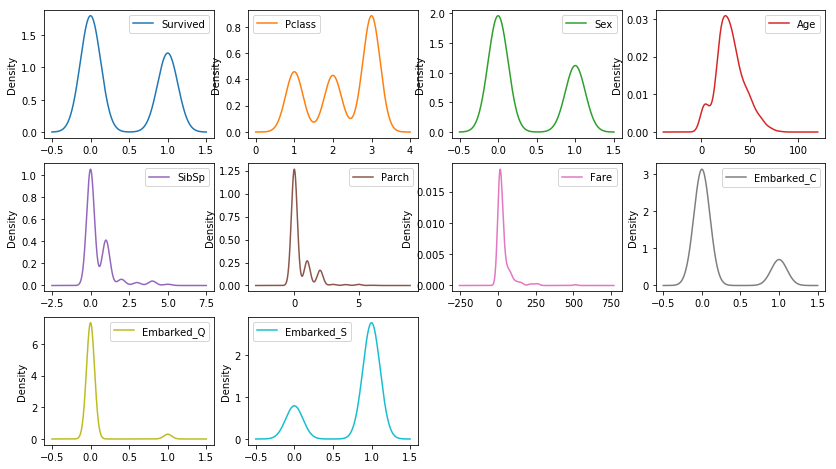

In [9]:
train.plot(kind='density', subplots=True, layout=(3,4), sharex=False, figsize = (14,8))
plt.show()

### Scatter matrix para cada par de atributos (incluindo saída)

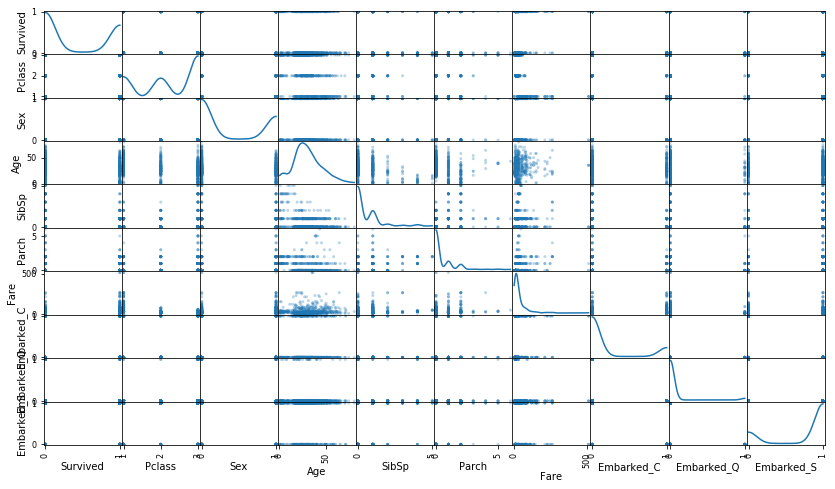

In [10]:
pd.scatter_matrix(train, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Box Plot

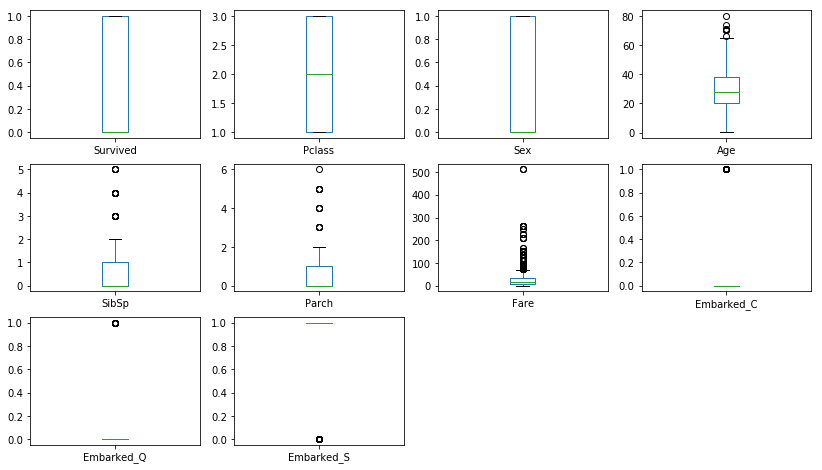

In [11]:
train.plot.box(subplots=True, layout=(3,4), sharex=False, figsize = (14,8))
plt.show()

# Solucionando Problemas

Os problemas podem ser solucionados utilizando algumas medidas estatísticas como média, mediana e moda para substituir as informações que estão faltando e dados discrepantes, ou excluir as instâncias. Além disso, quanto mais balanceado o dataset, menos propensa estará a rede a cometer erros de generalização. A resolução pode ser feita das duas formas utilizando o Pandas. 

### Agora vamos, de maneira simples, ignorar os outliers das colunas possivelmente problematicas

In [12]:
train = train[train["Age"] > train["Age"].quantile(0.05)]
train = train[train["Age"] < train["Age"].quantile(0.95)]

train = train[train["Fare"] > train["Fare"].quantile(0.05)]
train = train[train["Fare"] < train["Fare"].quantile(0.95)]

train = train[train["Parch"] < train["Parch"].quantile(0.95)]

display(train.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Survived,514.0,0.379377,0.485705,0.0000,0.00,0.0,1.0000,1.000
Pclass,514.0,2.270428,0.811000,1.0000,2.00,2.5,3.0000,3.000
Sex,514.0,0.332685,0.471634,0.0000,0.00,0.0,1.0000,1.000
Age,514.0,29.985409,10.921315,5.0000,22.00,28.5,36.0000,56.000
SibSp,514.0,0.375486,0.667443,0.0000,0.00,0.0,1.0000,4.000
Parch,514.0,0.140078,0.347406,0.0000,0.00,0.0,0.0000,1.000
Fare,514.0,24.596417,24.293738,7.2292,8.05,13.0,27.5406,113.275
Embarked_C,514.0,0.167315,0.373621,0.0000,0.00,0.0,0.0000,1.000
Embarked_Q,514.0,0.038911,0.193570,0.0000,0.00,0.0,0.0000,1.000
Embarked_S,514.0,0.793774,0.404989,0.0000,1.00,1.0,1.0000,1.000


# Correlação dos atributos

Uma vez que o dataset foi analisado e possíveis erros foram corrigidos, é importante também verificar a correlação dos atributos. A correlação é uma métrica estatística que mede a associação entre os atributos. Caso existam atributos altamente correlacionados, pode-se excluir alguns deles, permanecendo apenas um dos atributos correlacionados.

Dessa forma, nessa etapa, calcule a correlação entre os atributos. Considere utilizar algumas formas de visualização para melhor interpretação dos resultados.

In [13]:
train.corr(method='pearson', min_periods=1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
Survived,1.000000,-0.364884,0.562705,0.032833,0.028743,0.088778,0.304813,0.186624,0.008552,-0.176257
Pclass,-0.364884,1.000000,-0.164322,-0.409239,-0.065515,-0.037851,-0.741646,-0.297582,0.119099,0.217608
Sex,0.562705,-0.164322,1.000000,-0.048821,0.110175,0.167115,0.186722,0.114928,0.071450,-0.140177
Age,0.032833,-0.409239,-0.048821,1.000000,-0.082682,-0.068306,0.231051,0.029263,-0.080874,0.011659
SibSp,0.028743,-0.065515,0.110175,-0.082682,1.000000,0.335978,0.304280,0.060254,0.082837,-0.095181
Parch,0.088778,-0.037851,0.167115,-0.068306,0.335978,1.000000,0.162326,0.074389,0.034740,-0.085232
Fare,0.304813,-0.741646,0.186722,0.231051,0.304280,0.162326,1.000000,0.364121,-0.045271,-0.314281
Embarked_C,0.186624,-0.297582,0.114928,0.029263,0.060254,0.074389,0.364121,1.000000,-0.090194,-0.879437
Embarked_Q,0.008552,0.119099,0.071450,-0.080874,0.082837,0.034740,-0.045271,-0.090194,1.000000,-0.394756
Embarked_S,-0.176257,0.217608,-0.140177,0.011659,-0.095181,-0.085232,-0.314281,-0.879437,-0.394756,1.000000


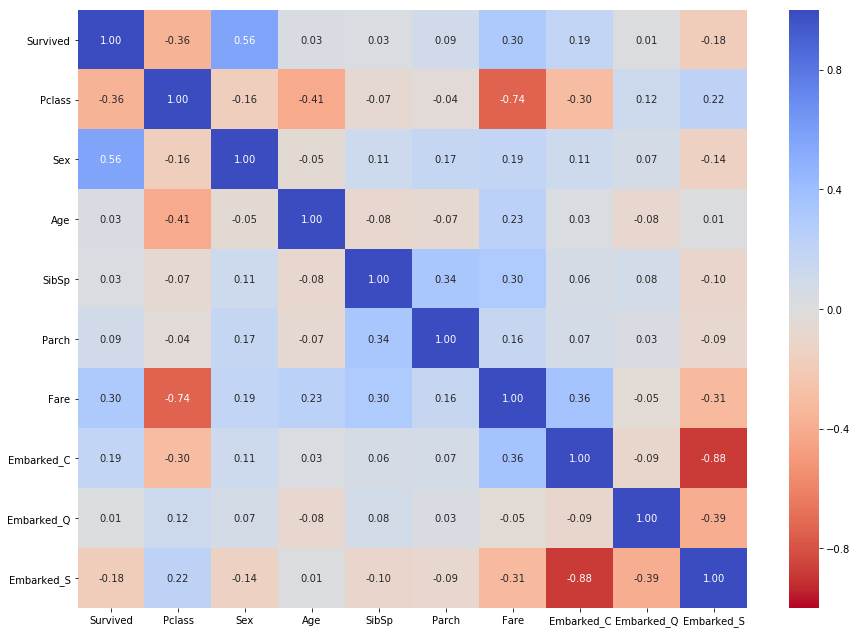

In [14]:
pylab.rcParams['figure.figsize'] = (15, 11)
fig = sns.heatmap(train[["Survived","Pclass","Sex","Age","SibSp","Parch","Fare", "Embarked_C", "Embarked_Q", "Embarked_S"]].corr(), 
            annot=True, cmap="coolwarm_r", vmin=-1, vmax=1, fmt=".2f")

# Implementando a Rede Neural

Uma vez que a base de dados foi analisada e possíveis problemas foram corrigidos, pode-se implementar a rede neural. Para esse problema, é necessário uma arquitetura multicamada MLP de no máximo 6 camadas escondidas, recomendando-se a implementação das camadas de forma gradual. Da mesma forma, cada camada deverá conter no máximo 30 neurônios. Além disso, recomenda-se a utilização de técnicas de regularização como Dropout, normalização do batch e normalização L2.

Utilize o otimizador de sua escolha para o treinamento por batch, aumente a quantidade de epochs e batch também gradativamente, não é necessário uma quantidade muito alta para resolução do problema. Ao final, mostre a curva de treinamento e a matriz de confusão obtida para o problema. 

In [15]:
# Separar atributos da saída
X_train = train.drop(columns=["Survived"]).as_matrix()[:-100]
y_train = train["Survived"].as_matrix()[:-100]

X_val = train.drop(columns=["Survived"]).as_matrix()[-100:]
y_val = train["Survived"].as_matrix()[-100:]

X_test =  test.as_matrix()
y_test =  None

print("X_train: ",len(X_train))
print("y_train: ",len(y_train))
print("X_val: ",len(X_val))
print("y_val: ",len(y_val))

X_train:  414
y_train:  414
X_val:  100
y_val:  100


### Modelo

In [16]:
model = Sequential()
model.add(Dense(20, input_dim=9, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Treinamento

In [17]:
epocas = 1000
start_time = time.time()
history = model.fit(X_train, y_train, epochs=epocas, batch_size=16, validation_data=(X_val, y_val), verbose=0, shuffle=True)
print("Tempo gasto: %d segundos" % (time.time() - start_time), "\r\nÉpocas: %d" % (epocas))

Tempo gasto: 62 segundos 
Épocas: 1000


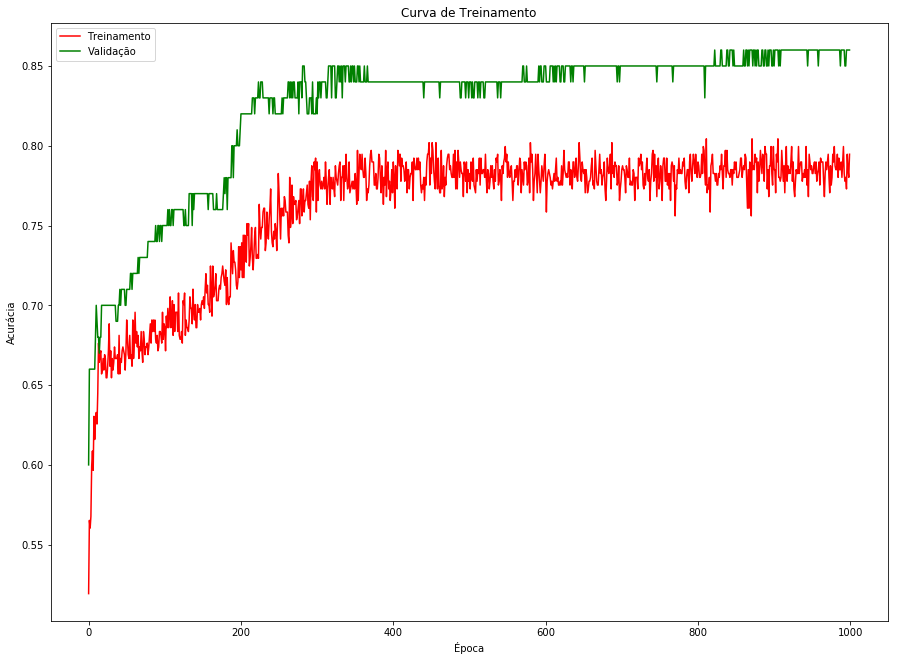

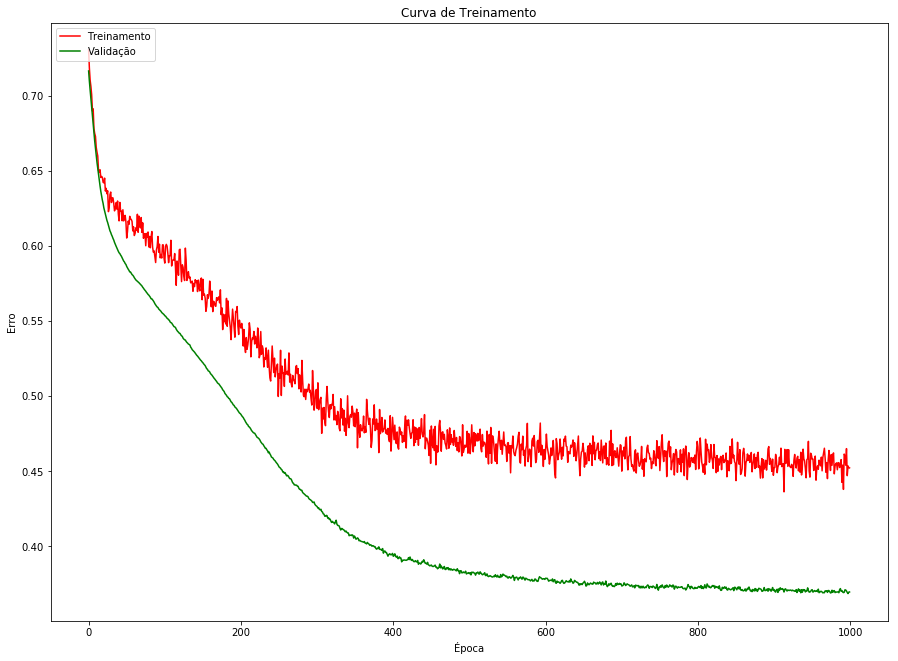

In [18]:
pylab.rcParams['figure.figsize'] = (15, 11)
plt.plot(history.history['acc'], color="r")
plt.plot(history.history['val_acc'], color="g")
plt.title('Curva de Treinamento')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()

pylab.rcParams['figure.figsize'] = (15, 11)
plt.plot(history.history['loss'], color="r")
plt.plot(history.history['val_loss'], color="g")
plt.title('Curva de Treinamento')
plt.ylabel('Erro')
plt.xlabel('Época')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()

## Resultados

### Matriz de Confusão (Treinamento)

Acurácia (Treinamento): 0.789855072464 



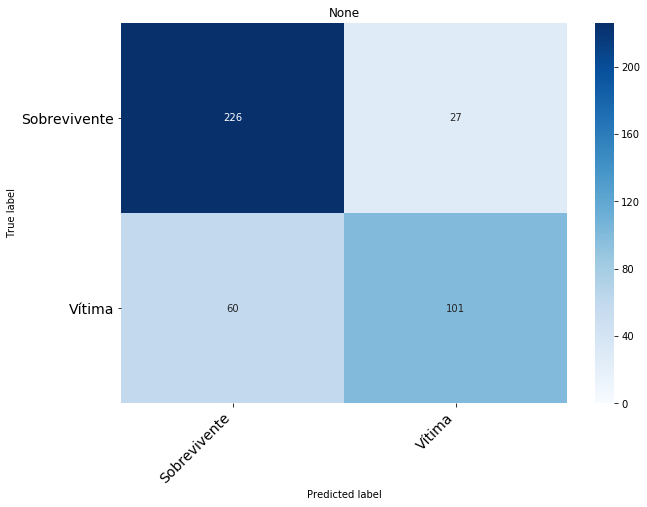

In [19]:
print("Acurácia (Treinamento):", accuracy_score(y_train, np.round(model.predict(X_train))), "\r\n")
fig = print_confusion_matrix(confusion_matrix(y_train, np.round(model.predict(X_train))),
                             ('Sobrevivente', 'Vítima'), cmap="Blues", vmin=0)

### Matriz de Confusão (Validação)

Acurácia (Validação): 0.86 



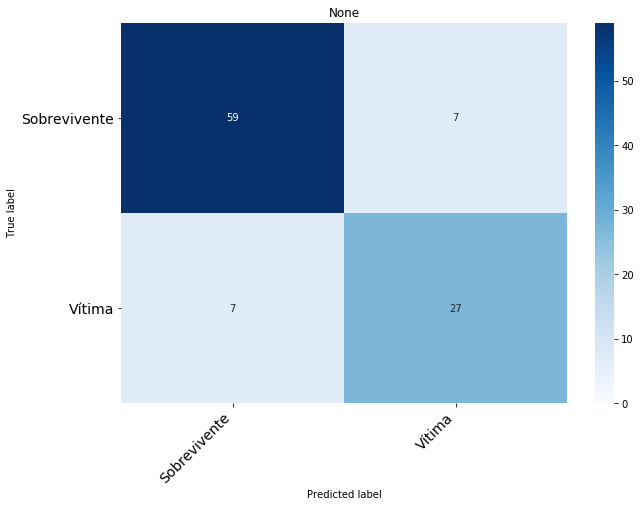

In [20]:
print("Acurácia (Validação):", accuracy_score(y_val, np.round(model.predict(X_val))), "\r\n")
fig = print_confusion_matrix(confusion_matrix(y_val, np.round(model.predict(X_val))),
                             ('Sobrevivente', 'Vítima'), cmap="Blues", vmin=0)